# General

Retrieval augmented generation is a technique introduced by researchers at Facebook AI Research (FAIR) in paper from 2020 titled "Retrieval-augmented Generation for Knowledge-Intensive NLP Tasks".

The idea behind RAG is that we can add knowledge to an already trained LLM by injecting into the context useful information retrieved after receiving the user's query. This is very useful because otherwise the only way to "add" new knowledge to an LLM would be to finetune the model over new data.

![rag_sequence_diagram](imgs/rag_seq_diagram.png)

Retrieval Augmented Generation systems are interesting for companies because it's a way to have a model that:
- their users can query about internal company procedures;
- can be updated "on the fly" by indexing new documents/reindexing updated documents;
- the company has total control over model knowledge base (i.e. a document is no longer relevant? Just remove it from the knowledge base);

Let's see a brief demo of how RAG works.

# Imports

In [1]:
from dotenv import load_dotenv

import os
import socket
from glob import glob
import re
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
from functools import partial

from datetime import datetime
import time
import random
import math

from typing import List

import pandas as pd
import numpy as np

from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain_openai import ChatOpenAI
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter, CharacterTextSplitter, MarkdownTextSplitter
from langchain_chroma.vectorstores import Chroma 
from langchain_huggingface import HuggingFaceEmbeddings

import chromadb
from chromadb.errors import NotFoundError
from rank_bm25 import BM25Okapi

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

from pydantic import BaseModel

/leonardo/home/userinternal/rmioli00/git/cinecaxtpc25/session_5/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Env config

In [2]:
t0 = datetime.now()
date = re.sub(r"[ :-]", "_", str(t0)[:19])
print(f"Last execution {t0}")

load_dotenv()

# Models
EMBEDDER = "BAAI/bge-m3"
RERANKER = "BAAI/bge-reranker-v2-m3"
LLM = "mistralai/Mistral-Small-3.1-24B-Instruct-2503"

# Endpoints
VLLM_OPENAI_ENDPOINT = os.environ["VLLM_OPENAI_ENDPOINT"]
VLLM_KEY = os.environ["VLLM_KEY"]

# Paths
PROMPT_PATH = "../data/prompts"
INPUT_PATH = "../data/input"
OUTPUT_PATH = "../data/output/chunking"

Path(OUTPUT_PATH).mkdir(exist_ok=True, parents=True)

# Use GPU 3 for this notebook. GPUs 0 and 1 are used to load the llm
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

llm = ChatOpenAI(base_url=VLLM_OPENAI_ENDPOINT, api_key=VLLM_KEY, model=LLM, temperature=0, max_completion_tokens=3000)

Last execution 2025-07-28 16:39:27.599879


# Why do we need RAG systems?

Let us evaluate the responses of an off-the-shelf pretrained model to a set of questions.

In [3]:
test_questions = ["What GPUs are available on Leonardo?", "Is there any partition without gpus?",
                  "What GPUs are available on the Cloud?", "Can I associate a domain name to a vm?",
                  "What are the naming conventions I should follow when asking for a domain name for a vm machine?",
                  "What is Cineca AI and how do I enable it?", 
                  "What are the names of the QOS queues available on the Leonardo supercomputer BOOSTER partition?"]

for question in test_questions:
    print(f"[QUESTION]: {question}")
    answ = llm.stream([("system", "You are an helpful assistant, answer to the user's questions in a precise and concise manner."),
                       ("human", question)])
    print("[ANSWER]: ", end="")
    for chunk in answ:
        print(chunk.content, end="")
    print("\n")

[QUESTION]: What GPUs are available on Leonardo?
[ANSWER]: As of my last update in October 2023, Leonardo, which is part of the EuroHPC Joint Undertaking, is designed to be one of the most powerful supercomputers in Europe. It is equipped with advanced GPUs to handle its high-performance computing tasks. Specifically, Leonardo is known to feature NVIDIA A100 GPUs. These GPUs are part of the NVIDIA Ampere architecture and are widely used in supercomputing and AI applications due to their high performance and efficiency.

For the most current and detailed information, I recommend checking the official EuroHPC or Leonardo supercomputer documentation, as hardware specifications can be updated or expanded over time.

[QUESTION]: Is there any partition without gpus?
[ANSWER]: Yes, there are partitions without GPUs. In many high-performance computing (HPC) environments, clusters are often divided into different partitions to cater to various types of workloads. Some common types of partitions

Except for the first answer, all the following answers are incorrect.

In [4]:
# We know where to find data, so we read the correspondent file. In a while we are going to automate also this step.
with open(os.path.join(INPUT_PATH, "leonardo.rst.txt"),  mode = "r") as f:
    data = f.readlines()

answ = llm.stream([("system", "You are an helpful assistant, answer to the user questions in a precise and concise manner."),
                   ("human", f"Given the following data, what are the names of the QOS queues available on the Leonardo supercomputer BOOSTER partition?\n\n{data}")])

for chunk in answ:
    print(chunk.content, end="")

The QOS queues available on the Leonardo supercomputer BOOSTER partition are:

- normal
- boost_qos_dbg
- boost_qos_bprod
- boost_qos_lprod
- boost_qos_fuabprod
- qos_fualowprio

In the following section, we will implement a Retrieval-Augmented Generation (RAG) system using the HPC documentation provided by Cineca to their users. As you will observe, the primary task in building RAG systems involves rigorously testing and evaluating different configurations of the information retrieval component to measure their impact on overall system performance. In a RAG pipeline, the generative AI component represents only the final stage of the process; the majority of the effort is dedicated to designing a robust retrieval system tailored to your data.  

In our case, the documents are in `.rst` format, so we are not concerned with reading files in other formats such as `.pdf` or `docx`. However, in real-world scenarios, this step can be handled using libraries such as marker, docling, or similar tools, depending on your needs. In this tutorial, we will not focus on document parsing, as our files are already in raw text format. Additionally, the choice of parsing libraries is highly dependent on the structure of your data and your specific preferences.

## RAG building blocks

The development and deployment of a RAG system typically involves five main steps:

1. **loading** documents from a data source;
2. **chunking** these documents in some (optimal) way;
3. **storing** the chunked data in a vector database;
4. **retrieving** relevant data to answer user queries;
5. passing the **retrieve**d data to an LLM for generation.

Steps 1 to 3 are performed "offline", while steps 4 and 5 are executed "online".

# Classical information retrieval approaches

Classical information retrieval systems operated by matching keywords in user queries with terms found in document collections, ranking documents based on **term frequency and inverse document frequency (TF-IDF)** without understanding the meaning of words. For example, bag-of-words models represented documents as unordered collections of terms, capturing term frequency but ignoring word order and context; search engines would then rank documents with the highest TF-IDF scores for the query terms.  

Another classical approach was **exact match retrieval using tags**, where documents were labeled with controlled keywords (tags), and retrieval was based on finding documents with matching tags, as in early library catalogs or enterprise document management systems. 

# Semantic search

In contrast, semantic search goes beyond exact term matching by **using vector representations (embeddings) of documents and queries**, capturing the meaning of words and their relationships. This allows retrieval systems to surface relevant documents even when they do not contain the exact keywords used in the query but are semantically related, enabling systems to understand that "car" and "automobile" refer to the same concept or that a document discussing "heart attacks" may be relevant for the query "myocardial infarction."

![embeddings](imgs/use-transformer-variant.png)

![embeddings_2](imgs/use-goal.png)


Image courtesy of: https://amitness.com/posts/universal-sentence-encoder.

The embedding phase is performed twice: over the documents, and over the query. Then, we search the document (chunk) with the lower distance with respect to the query.

## Chunking

To compute document embeddings effectively, it is necessary to partition the text before processing. This requirement arises from the **limited context length** of embedding models. For example:

- The `BAAI/bge-m3 embedder` supports a maximum sequence length of approximately 8,000 tokens.
- The `all-mpnet-base-v2` model has a context length limit of 384 tokens.
- The `all-MiniLM-L12-v2` model allows a maximum sequence length of 256 tokens.

These limitations define the upper bound for the sequence length we can embed at once.

We will now evaluate various chunking strategies on our document collection.

In [5]:
INPUT_DOCS = glob(os.path.join(INPUT_PATH, "*"))
INPUT_DOCS[:10]

['../data/input/generic_share_create.rst.txt',
 '../data/input/database.rst.txt',
 '../data/input/hpc_software.rst.txt',
 '../data/input/gaia.rst.txt',
 '../data/input/miniconda.rst.txt',
 '../data/input/secgroups_create.rst.txt',
 '../data/input/index_storage_ops.rst.txt',
 '../data/input/interactive_computing.rst.txt',
 '../data/input/security_guidelines.rst.txt',
 '../data/input/fip_association.rst.txt']

In [6]:
# Create a list of document, with some metadata associated to each document.
documents = []

for doc in INPUT_DOCS:
    with open(doc) as f:
        documents.append(Document(f.read(), metadata={"doc_name":doc.split("/")[-1], "scraped_on": "2025-07-22"}))
        
documents[0]

Document(metadata={'doc_name': 'generic_share_create.rst.txt', 'scraped_on': '2025-07-22'}, page_content='.. _shares_generic_create_card:\n\nCreate and use a GENERIC_TYPE share\n===================================\n\nThe following sections describe the steps needed to create a share and mount it on two VMs attached to a local network. \nNote that the user needs to configure the VMs in a way that allows logging in via ssh. \n\nRequest to be enabled to the service\n------------------------------------\n\nThe user willing to make use of the Manila service needs to send an email to superc@cineca.it, communicating \n\n- how many shares are needed.\n- their dimensions (GB).\n- the tenant\'s name.\n\nOnce the tenant is enabled to the service by the User Support Team, all users of the tenant will be able to use the service. \n\nCreate share network\n--------------------\n\nAs a first step, in the :ref:`cloud/os_overview/management_tools/dashboard:horizon dashboard` you need to create the share

These are some of the most basic chunking strategies:

1. `Sentence length`: Split documents so that each sequence has a fixed length based on character length.
2. `Recursive Character Text Splitter`: Split documents so that each sequence is **at most** a specified length **and ends at a designated delimiter** character (e.g., punctuation `\n`, etc).
3. `Format-specific text splitters`: Similar to the above, but designed specifically for certain formats such as Markdown, HTML, Python code, etc., to preserve structure and syntax (these splitters use specific delimiters based on the format you are splitting).

In [7]:
# Split at char level, 100 chars max, 0 overlap between chunks
cts = CharacterTextSplitter(separator="", chunk_size = 100, chunk_overlap = 0)

cts.split_text(documents[0].page_content)[:10]

['.. _shares_generic_create_card:\n\nCreate and use a GENERIC_TYPE share\n===============================',
 '====\n\nThe following sections describe the steps needed to create a share and mount it on two VMs att',
 'ached to a local network. \nNote that the user needs to configure the VMs in a way that allows loggin',
 'g in via ssh. \n\nRequest to be enabled to the service\n------------------------------------\n\nThe user',
 'willing to make use of the Manila service needs to send an email to superc@cineca.it, communicating',
 "- how many shares are needed.\n- their dimensions (GB).\n- the tenant's name.\n\nOnce the tenant is en",
 'abled to the service by the User Support Team, all users of the tenant will be able to use the servi',
 'ce. \n\nCreate share network\n--------------------\n\nAs a first step, in the :ref:`cloud/os_overview/man',
 'agement_tools/dashboard:horizon dashboard` you need to create the share network \nby clicking on *"Cr',
 'eate Share Network"* in *"Share â\x8

In [8]:
# Here, chunk size is an upper limit. This splitter attempts to create 
# chunks close to this size, but will split earlier by following a hierarchy of separators.
rcts = RecursiveCharacterTextSplitter(chunk_size = 100, chunk_overlap = 0)

rcts.split_text(documents[0].page_content)[:10]

['.. _shares_generic_create_card:',
 'Create and use a GENERIC_TYPE share\n===================================',
 'The following sections describe the steps needed to create a share and mount it on two VMs attached',
 'to a local network.',
 'Note that the user needs to configure the VMs in a way that allows logging in via ssh.',
 'Request to be enabled to the service\n------------------------------------',
 'The user willing to make use of the Manila service needs to send an email to superc@cineca.it,',
 'communicating',
 "- how many shares are needed.\n- their dimensions (GB).\n- the tenant's name.",
 'Once the tenant is enabled to the service by the User Support Team, all users of the tenant will be']

Typically, we use token length rather than character length for chunking because when working with embedders, **the maximum context length is defined in tokens, not characters**.  

We can count the number of tokens using the embedder’s tokenizer and then split the document with a strategy similar to the Recursive Character Text Splitter (RCTS), but based on the token count as the chunk size.  

The embedder we are using for this tutorial has a maximum context length of 8k tokens, this will be our upper limit. 

In [9]:
embedder = SentenceTransformer(EMBEDDER)
embedder.max_seq_length

8192

In [10]:
stts = SentenceTransformersTokenTextSplitter(tokens_per_chunk=75, chunk_overlap=0, model_name=EMBEDDER)

print(documents[0].metadata)
for chunk in stts.split_text(documents[0].page_content)[:2]:
    print(f"[CHUNK_CONTENT]:\n{chunk}\n===========")

{'doc_name': 'generic_share_create.rst.txt', 'scraped_on': '2025-07-22'}
[CHUNK_CONTENT]:
.. _shares_generic_create_card: Create and use a GENERIC_TYPE share =================================== The following sections describe the steps needed to create a share and mount it on two VMs attached to a local network. Note that the user needs to configure the VMs in a way that allows logging in via ssh.
[CHUNK_CONTENT]:
Request to be enabled to the service ------------------------------------ The user willing to make use of the Manila service needs to send an email to superc@cineca.it, communicating - how many shares are needed. - their dimensions (GB). - the tenant's name. Once the tenant is enabled to the service by the User Support Team,


The problem of the aformentioned method is that `SentenceTransformersTokenTextSplitter` does not support the use of specific separators. But we can create a recursive character text splitter using an huggingface tokenizer.

In [11]:
rcts_hftokenizer = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(embedder.tokenizer, chunk_overlap = 0, chunk_size = embedder.max_seq_length)
rcts_hftokenizer._separators = [".", ",", "\n\n", "\n", " ", ""]

print(documents[0].metadata)
# Our embedder has a context length of 8k tokens, which is big... that's why you see only a single chunk here.
# What do you think it would happen if we use an embedder with a limited max sequence length?
for chunk in rcts_hftokenizer.split_text(documents[0].page_content)[:2]:
    print(f"[CHUNK_CONTENT]:\n{chunk}\n===========")

{'doc_name': 'generic_share_create.rst.txt', 'scraped_on': '2025-07-22'}
[CHUNK_CONTENT]:
.. _shares_generic_create_card:

Create and use a GENERIC_TYPE share

The following sections describe the steps needed to create a share and mount it on two VMs attached to a local network. 
Note that the user needs to configure the VMs in a way that allows logging in via ssh. 

Request to be enabled to the service
------------------------------------

The user willing to make use of the Manila service needs to send an email to superc@cineca.it, communicating 

- how many shares are needed.
- their dimensions (GB).
- the tenant's name.

Once the tenant is enabled to the service by the User Support Team, all users of the tenant will be able to use the service. 

Create share network
--------------------

As a first step, in the :ref:`cloud/os_overview/management_tools/dashboard:horizon dashboard` you need to create the share network 
by clicking on *"Create Share Network"* in *"Share â Share Netw

Other chunking options we will not explore today:

- Semantic chunking
- LLM based chunking

# Finding the right chunk size

It is true that the maximum sequence length of our embedder imposes an upper limit on the size of the embeddings. However, this does not imply that this upper limit corresponds to the optimal chunk size. **Larger chunks often encompass multiple topics, which can result in embeddings that are less focused** and "dilute" the thematic coherence.

How can we determine the optimal chunk size?

If a labeled dataset of questions and answers is available, various evaluation metrics can be used to measure how the relevance of retrieved resources changes with different chunk sizes.

In [12]:
%%time
class QA:
    def __init__(self, document_name:str, question:str, answer:str, start_index:int, end_index:int, chunk_size_tok:int, seed:float):
        self.document_name = document_name # The document name containing the answ
        self.question = question # The question created by an llm
        self.answer = answer # The answer 
        self.start_index = start_index # Character index where the question starts
        self.end_index = end_index # Character index where the question ends
        self.chunk_size_tok = chunk_size_tok # Total token size
        self.seed = seed # Seed used to create the answ

# Let's generate a set of syntetic questions and answers
def generate_qa_pairs(document:Document, embedder:SentenceTransformer, 
                      llm:ChatOpenAI, seed:float|None = None) -> QA:
    """
    Extracts a list of questions and answers from the given document.

    Args:
        document (langchain.Document): The document from which to extract an answer chunk for question generation.
        embedder: The embedder to be used in the process.
        llm (langchain.LLM): An instance of a Langchain LLM used for generating questions.
        seed (float, optional): A seed value to ensure reproducibility. If None (default), the current Unix timestamp will be used.

    Returns:
        QA Object: An object containing the question-answer data with the following fields:
            - `document_name`: The name of the source document.
            - `question`: The generated question corresponding to the extracted chunk.
            - `answer`: The answer text extracted from the document.
            - `start_index`: The starting index of the answer within the document.
            - `end_index`: The ending index of the answer within the document.
            - `chunk_size_tok`: The size of the chunk in tokens.
            - `seed`: The seed value used to select the answer for question generation.
    """
    try:
        # Set a seed for replicability
        if seed is None:
            seed = time.time()
        random.seed(seed)
        
        # Here we don't use always the same sequence length, otherwise we are
        # influencing our average chunks length to be always that long
        rand_seq_len = random.randint(100, 1024)

        chunker = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(embedder.tokenizer, 
                                                                            chunk_overlap = 0, 
                                                                            chunk_size = rand_seq_len,
                                                                            add_start_index = True)
        chunker._separators = ["..", ",", "\n\n", "\n", " ", ""]

        # Extract the answer to be used for question generation.
        document_chunks = chunker.split_documents([document])
        # Add end index to the document metadata
        for i in range(len(document_chunks)):
            document_chunks[i].metadata["end_index"] = document_chunks[i].metadata["start_index"] + len(document_chunks[i].page_content) - 1 
            
        # Select a random chunk so that we don't always generate the same
        # set of Q&A pairs
        answer = document_chunks[random.randint(0, len(document_chunks)-1)]

        # Use an llm to generate a question about this piece of text
        class AnswerFormat(BaseModel):
            question:str

        with open(os.path.join(PROMPT_PATH, "qa_syntetic_testset_prompt.txt"), mode = "r") as f:
            # Read the question prompt and append the content of the document to the end
            question_template = f.read() + "\n" + answer.page_content
        
        item = llm.with_structured_output(AnswerFormat).invoke(question_template)
        return QA(answer.metadata["doc_name"], item.question, 
                  answer.page_content, answer.metadata["start_index"], answer.metadata["end_index"], 
                  len(embedder.tokenizer.tokenize(answer.page_content)), seed)
    except Exception as e:
        print(f"Encountered an exception while processing doc {document.metadata['doc_name']}", e)
        return QA(document.metadata["doc_name"], "Error while parsing doc", e, 0, 0, 0, seed)

with ThreadPoolExecutor(max_workers=12) as e:
    results = [*e.map(partial(generate_qa_pairs, embedder = embedder, llm = llm, seed = 42), documents)]

CPU times: user 1.73 s, sys: 22 ms, total: 1.75 s
Wall time: 9.15 s


In [13]:
qa_set = pd.DataFrame({"doc": [qa.document_name for qa in results], "seed":[qa.seed for qa in results],
                       "chunk_size_tok": [qa.chunk_size_tok for qa in results],  
                       "start_index": [qa.start_index for qa in results], "end_index": [qa.end_index for qa in results],
                       "question": [qa.question for qa in results], "answer": [qa.answer for qa in results]})
display(qa_set.head())

# Save to csv for further inspection
qa_set.to_csv(os.path.join(OUTPUT_PATH, f"qa_questions_{date}.csv"), index = False)

,doc,seed,chunk_size_tok,start_index,end_index,question,answer
0,generic_share_create.rst.txt,42,644,0,2429,What specific details must a user include in t...,.. _shares_generic_create_card:\n\nCreate and ...
1,database.rst.txt,42,220,0,1019,How does the Trove component of OpenStack faci...,.. _database_card:\n\nDatabase\n========\n\n`T...
2,hpc_software.rst.txt,42,734,0,3131,What steps must a user take to gain access to ...,"Software\n========\n\n| On CINECA clusters, se..."
3,gaia.rst.txt,42,471,0,1611,What are the specific models of Nvidia GPUs th...,.. _gaia_card:\n\nGAIA\n====\n\n**PAGE UNDER C...
4,miniconda.rst.txt,42,737,0,3062,What are the recommended steps to clean up pre...,.. _miniconda_card:\n\nMiniconda \n=========\n...


In [14]:
# Note: Questions and answers may vary due to multithreading even if we set a seed, that's because multithreading may change the order of execution.
# So we load this Q&A set to ensure replicability of the next steps
qa_set = pd.read_csv("../data/output/chunking/qa_questions_2025_07_23_14_54_35.csv")

## Mean Reciprocal Rank

$ MeanReciprocalRank = \frac{1}{|Q|} \sum_{i=1}^{|Q|}\frac{1}{rank_i} $

Given a set of questions $ Q $, we rank all available chunks by their similarity to each question and examine the position of the relevant chunk within this ranking. The average of the reciprocal ranks across all questions is known as the $ Mean Reciprocal Rank $ (MRR).

To identify the optimal chunk size, the following procedure can be employed:

1. Define a test set with questions and their related answers (we can do it manually or... with an LLM). We already done this step;
2. Chunk data testing various configurations of chunk sizes (e.g. 100 tokens, 200 tokens, etc..);
3. For each chunk config, calculate the mean reciprocal rank;
4. Choose the chunking configuration which maximizes the MRR (the MRR is constrained between 0 and 1; so, the higher the better) and minimizes the chunk size.

## Test various chunking config

We experiment with various chunking setups as described earlier. We start with an initial chunk size of 100 tokens and increase it by 100 tokens each time.

Although our embedder supports a context window of around 8000 tokens, we limit the maximum chunk size to 1500 tokens. This is because beyond 1500 tokens, the text chunks become quite long, and we want to avoid making them overly broad in terms of topics.

In [15]:
def find_optimal_chunk_size(initial_chunk_size:int, step_size:int, max_chunk_size:int, 
                            documents:List[Document], qa_set:pd.DataFrame) -> pd.DataFrame:
    # Save the mean reciprocal rank for each config tested
    tested_chunk_size = []
    mean_reciprocal_rank = []

    for chunk_size in range(initial_chunk_size, max_chunk_size + 1, step_size):
        print(f"{datetime.now()} - Testing chunk size of: {chunk_size}")
        rcts_chunker = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(embedder.tokenizer, 
                                                                                chunk_overlap = 0, 
                                                                                chunk_size = chunk_size,
                                                                                add_start_index = True)
        # The . was removed as in rst documents it has a very specific meaning 
        # and this would cause document "oversplitting"
        rcts_chunker._separators = ["..", ",", "\n\n", "\n", " ", ""]

        # The split_documents method creates one document for each chunk. Each document has the same metadata 
        # as the original document. The list is "flat", we don't have nested lists
        splitted_docs = rcts_chunker.split_documents(documents)
        # Add end position for each chunk
        for chunk in splitted_docs:
            chunk.metadata["end_index"] = chunk.metadata["start_index"] + len(chunk.page_content) - 1 

        # Calculate the embedding for each document chunk
        documents_embeddings = embedder.encode([chunk.page_content for chunk in splitted_docs])
        embedded_data = pd.DataFrame({"content":[chunk.page_content for chunk in splitted_docs],
                                    "metadata": [chunk.metadata for chunk in splitted_docs],
                                    "embeddings": [embeddings for embeddings in documents_embeddings]})

        # Unpack metadata columns
        embedded_data[[item for item in embedded_data["metadata"].iloc[0].keys()]] = embedded_data.apply(lambda x: [item for item in x["metadata"].values()], axis = 1, result_type="expand")
        embedded_data.drop("metadata", axis = 1, inplace = True)

        # Embed each question and calc similarity with respect to the chunks
        # created with the chunk size configuration we are testing
        embedded_questions = embedder.encode(qa_set["question"])
        similarity = cosine_similarity(embedded_questions, np.stack(embedded_data["embeddings"].to_numpy()))

        # Create a table with question_id, chunk_id, similarity score
        similarity_abt = pd.DataFrame(similarity).stack().reset_index()
        similarity_abt.columns = ["question_id", "chunk_id", "similarity"]

        # Add chunk informations
        similarity_abt = similarity_abt.merge(embedded_data.reset_index(), how="inner", left_on = "chunk_id", right_on= "index")
        similarity_abt.drop(["index", "embeddings", "scraped_on"], axis=1, inplace=True)
        similarity_abt.rename({"start_index": "chunk_start_index", "end_index":"chunk_end_index", "doc_name":"chunk_doc_provenance", "content":"chunk_content"}, axis = 1, inplace=True)

        # Join qa set information
        similarity_abt = similarity_abt.merge(qa_set.reset_index(), how="inner", left_on = "question_id", right_on= "index")
        similarity_abt.drop(["index", "seed", "chunk_size_tok"], axis=1, inplace=True)
        similarity_abt.rename({"start_index": "answer_start_index", "end_index":"answer_end_index", "doc":"qa_doc_provenance"}, axis = 1, inplace=True)    
        #display(similarity_abt[["question_id", "chunk_id", "similarity", "chunk_doc_provenance", "chunk_start_index", "chunk_end_index", 
        #                        "qa_doc_provenance", "chunk_start_index","chunk_end_index", "question", "answer", "chunk_content"]])
        #break
        
        def calc_rank(df:pd.DataFrame):
            # Sort all the values and use the index as rank
            df = df.sort_values(by = "similarity", ascending = False).reset_index(drop = True)
            # Keep only rows where qa question matches chunk document provenance 
            # and where chunk contains a piece of the answer
            relevant_docs = df["chunk_doc_provenance"] == df["qa_doc_provenance"]
            chunk_contains_beginning_answ = df["answer_start_index"].between(df["chunk_start_index"], df["chunk_end_index"])
            chunk_contains_end_answ = df["answer_end_index"].between(df["chunk_start_index"], df["chunk_end_index"])
            chunk_contains_mid_answ = (df["chunk_start_index"] > df["answer_start_index"]) & (df["chunk_end_index"] < df["answer_end_index"])
            df = df[relevant_docs & ( chunk_contains_beginning_answ | chunk_contains_end_answ | chunk_contains_mid_answ)]
            df = df.reset_index(names = "rank")
            return df["rank"].mean()
            
        # For each question of the qa, calc the (avg) rank
        rank = similarity_abt.groupby("question_id").apply(lambda X: calc_rank(X), include_groups = False)
        reciprocal_rank = rank.map(lambda x: 1/(x + 1)) # Rank starts from zero, so we remap from 1 adding a + 1
        mrr = (1/rank.shape[0]) * sum(reciprocal_rank)
        
        # Save results for plotting
        mean_reciprocal_rank.append(mrr)
        tested_chunk_size.append(chunk_size)
    
    # Check mrr trend and plot against the chunk size
    mrr_tests_data = pd.DataFrame({"chunk_size": tested_chunk_size, "mrr": mean_reciprocal_rank})
    mrr_tests_data["improvement"] = mrr_tests_data["mrr"].diff(1)
    return mrr_tests_data

In [16]:
%%time
mrr_test_data = find_optimal_chunk_size(initial_chunk_size = 100, step_size = 100, max_chunk_size = 1500, documents = documents, qa_set = qa_set)

2025-07-28 16:40:24.248507 - Testing chunk size of: 100
2025-07-28 16:40:32.288890 - Testing chunk size of: 200
2025-07-28 16:40:38.834541 - Testing chunk size of: 300
2025-07-28 16:40:45.030032 - Testing chunk size of: 400
2025-07-28 16:40:51.192913 - Testing chunk size of: 500
2025-07-28 16:40:57.272516 - Testing chunk size of: 600
2025-07-28 16:41:03.475425 - Testing chunk size of: 700
2025-07-28 16:41:09.648438 - Testing chunk size of: 800
2025-07-28 16:41:15.897295 - Testing chunk size of: 900
2025-07-28 16:41:22.109958 - Testing chunk size of: 1000
2025-07-28 16:41:28.252650 - Testing chunk size of: 1100
2025-07-28 16:41:34.423317 - Testing chunk size of: 1200
2025-07-28 16:41:40.952498 - Testing chunk size of: 1300
2025-07-28 16:41:47.153977 - Testing chunk size of: 1400
2025-07-28 16:41:53.681691 - Testing chunk size of: 1500
CPU times: user 1min 50s, sys: 174 ms, total: 1min 50s
Wall time: 1min 36s


,chunk_size,mrr,improvement
0,100,0.058761,NaN
1,200,0.204699,0.145937
2,300,0.366927,0.162228
3,400,0.482120,0.115193
4,500,0.602926,0.120806
5,600,0.670944,0.068018
6,700,0.780495,0.109551
7,800,0.929104,0.148610
8,900,0.935323,0.006219
9,1000,0.907046,-0.028278


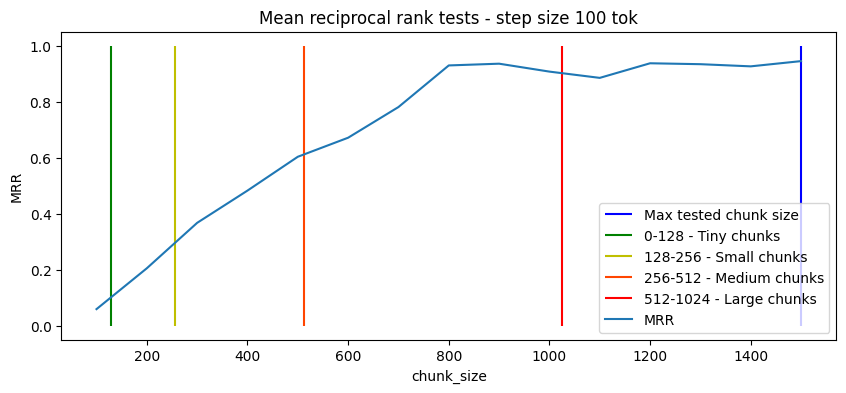

In [17]:
display(mrr_test_data)

plt.figure(figsize=(10, 4))
plt.vlines(mrr_test_data["chunk_size"].iloc[-1], ymin=0, ymax=1, colors = "b", label = "Max tested chunk size")
plt.vlines(128, ymin=0, ymax=1, colors = "g", label = "0-128 - Tiny chunks")
plt.vlines(256, ymin=0, ymax=1, colors = "y", label = "128-256 - Small chunks")
plt.vlines(512, ymin=0, ymax=1, colors = "orangered", label = "256-512 - Medium chunks")
plt.vlines(1024, ymin=0, ymax=1, colors = "r", label = "512-1024 - Large chunks")
plt.plot(mrr_test_data["chunk_size"], mrr_test_data["mrr"], label = "MRR")
plt.ylabel("MRR")
plt.xlabel("chunk_size")
plt.title(f"Mean reciprocal rank tests - step size {int(mrr_test_data['chunk_size'].diff().iloc[1])} tok")
plt.legend()
plt.show()

# Chunk and index all documents

Once we found a reasonable chunk size, we are ready to split all our docs with the chosen lenght. Then we need to save our collection of splitted docs in a [vector database](https://weaviate.io/blog/vector-library-vs-vector-database).

## Vector databases

A vector database is a specialized type of database designed to efficiently store and search data represented as high-dimensional vectors. These databases are optimized to perform similarity searches efficiently. Given a query vector, the database quickly finds vectors that are closest to it in terms of distance metrics like cosine similarity, Euclidean distance, etc.  

The choice of a vector database depends on the needs of the project, for a comparison see: [1](https://www.datacamp.com/blog/the-top-5-vector-databases#5-best-vector-databases-in-2025-theli), [2](https://benchmark.vectorview.ai/vectordbs.html), [3](https://medium.com/the-ai-forum/which-vector-database-should-you-use-choosing-the-best-one-for-your-needs-5108ec7ba133). More “traditional” dbs have added support for vectors (e.g. Postgres, DuckDB).  

For this tutorial we are going to use ChromaDB.

In [18]:
# Instantiate our splitter with the chunk size we identified during the previous step
rcts_chunker = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(embedder.tokenizer, 
                                                                         chunk_overlap = 0, 
                                                                         chunk_size = 800,
                                                                         add_start_index = True)
rcts_chunker._separators = ["..", ",", "\n\n", "\n", " ", ""]

chunks = rcts_chunker.split_documents(documents)
chunks[:2]

[Document(metadata={'doc_name': 'generic_share_create.rst.txt', 'scraped_on': '2025-07-22', 'start_index': 0}, page_content='.. _shares_generic_create_card:\n\nCreate and use a GENERIC_TYPE share\n===================================\n\nThe following sections describe the steps needed to create a share and mount it on two VMs attached to a local network. \nNote that the user needs to configure the VMs in a way that allows logging in via ssh. \n\nRequest to be enabled to the service\n------------------------------------\n\nThe user willing to make use of the Manila service needs to send an email to superc@cineca.it, communicating \n\n- how many shares are needed.\n- their dimensions (GB).\n- the tenant\'s name.\n\nOnce the tenant is enabled to the service by the User Support Team, all users of the tenant will be able to use the service. \n\nCreate share network\n--------------------\n\nAs a first step, in the :ref:`cloud/os_overview/management_tools/dashboard:horizon dashboard` you need 

Text(0, 0.5, 'Freq')

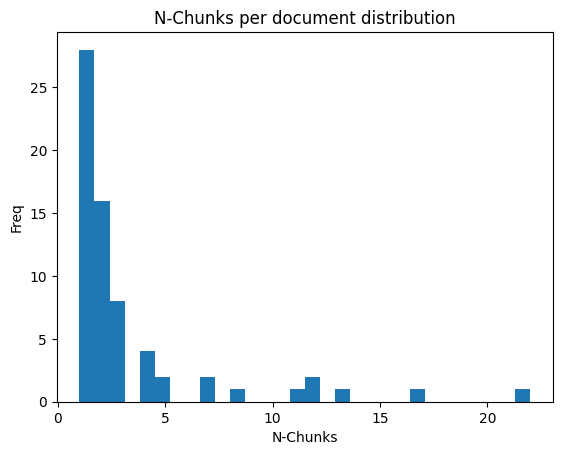

In [19]:
# Let's check the chunk distribution
chunk_count = pd.DataFrame([chunk.metadata for chunk in chunks]).groupby("doc_name").count().iloc[:, 1]
chunk_count.name = "chunk_count"

plt.hist(chunk_count, bins=30)
plt.title("N-Chunks per document distribution")
plt.xlabel("N-Chunks")
plt.ylabel("Freq")

In [20]:
# Util function to create embeddings and add them to a chromadb collection
def create_vector_store(documents:List[Document], embedder, 
                        vector_store_name:str, writing_path:str, is_incremental:bool = True):
    embeddings = embedder.encode([doc.page_content for doc in documents])

    chroma_client = chromadb.PersistentClient(path = writing_path)
    
    if not is_incremental:
        # Drop collection if exists, we want to start from a fresh state
        try:
            chroma_client.delete_collection(vector_store_name)
        except NotFoundError as e:
            pass
    collection = chroma_client.create_collection(name = vector_store_name, get_or_create=True)

    # Add all docs to the collection
    collection.add(documents = [doc.page_content for doc in chunks],
                metadatas  = [doc.metadata for doc in chunks],
                ids = [doc.metadata["doc_name"] + "__" + \
                        str(doc.metadata["start_index"]) for doc in chunks],
                embeddings = embeddings)

In [21]:
# Initialize our vector store
chroma_path = os.path.join(OUTPUT_PATH, "chroma")
Path(chroma_path).mkdir(exist_ok=True, parents=True)

create_vector_store(documents = chunks, embedder = embedder, 
                    vector_store_name="hpc_wiki", writing_path = chroma_path, is_incremental = False)

In [22]:
# Create a client for the db and check the top 3 retrieved docs for a question
lc_embedder = HuggingFaceEmbeddings(model_name = EMBEDDER)
hpc_store = Chroma(collection_name = "hpc_wiki", embedding_function = lc_embedder, 
                   persist_directory= chroma_path)
hpc_store.similarity_search_with_score("What are the names of the QOS queues available on the Leonardo supercomputer BOOSTER partition?", k=3)

[(Document(id='leonardo.rst.txt__0', metadata={'start_index': 0, 'scraped_on': '2025-07-22', 'doc_name': 'leonardo.rst.txt'}, page_content='.. _leonardo_card:\n\nLeonardo\n========\n\nLeonardo is the *pre-exascale* Tier-0 supercomputer of the EuroHPC Joint Undertaking (JU), hosted by **CINECA** and currently located at the Bologna DAMA-Technopole in Italy.\nThis guide provides specific information about the **Leonardo** cluster, including details that differ from the general behavior described in the broader HPC Clusters section.\n\n.. |ico2| image:: img/leonardo_logo.png\n   :height: 55px\n   :class: no-scaled-link\n\nAccess to the System\n--------------------\n\nThe machine is reachable via ``ssh`` (secure Shell) protocol at hostname point: **login.leonardo.cineca.it**. \n\nThe connection is established, automatically, to one of the available login nodes. It is possible to connect to **Leonardo** using one the specific login hostname points:\n\n * login01-ext.leonardo.cineca.it\n * l

Maybe the answer can improve a bit if we add more retrieved documents...

In [23]:
hpc_store.similarity_search_with_score("What are the names of the QOS queues available on the Leonardo supercomputer BOOSTER partition?", k=20)

[(Document(id='leonardo.rst.txt__0', metadata={'scraped_on': '2025-07-22', 'start_index': 0, 'doc_name': 'leonardo.rst.txt'}, page_content='.. _leonardo_card:\n\nLeonardo\n========\n\nLeonardo is the *pre-exascale* Tier-0 supercomputer of the EuroHPC Joint Undertaking (JU), hosted by **CINECA** and currently located at the Bologna DAMA-Technopole in Italy.\nThis guide provides specific information about the **Leonardo** cluster, including details that differ from the general behavior described in the broader HPC Clusters section.\n\n.. |ico2| image:: img/leonardo_logo.png\n   :height: 55px\n   :class: no-scaled-link\n\nAccess to the System\n--------------------\n\nThe machine is reachable via ``ssh`` (secure Shell) protocol at hostname point: **login.leonardo.cineca.it**. \n\nThe connection is established, automatically, to one of the available login nodes. It is possible to connect to **Leonardo** using one the specific login hostname points:\n\n * login01-ext.leonardo.cineca.it\n * l

# Evaluating k-size in the retrieval step

We can use the previously created Q&A set to tune the parameter k, which indicates the number of documents returned by the vector search.
We are interested in observing how the number of relevant chunks returned for each question changes when we increment k.  

In this case, we consider a chunk to be “relevant” if it comes from the document that answers the question we are evaluating.

## Precision and recall

We can use the precision@k and recall@k metric, which are defined as:

$Precision@k = \frac{\#Relevant Documents Retrieved}{K}$

Precision@k indicates, for a given query, the proportion of retrieved documents that are relevant out of the total number of documents retrieved.

$Recall@k = \frac{\#Relevant Documents Retrieved}{\#Relevant Documents Total}$

The Recall@k indicates, for a given query, how many relevant documents were left out.  

In [24]:
def optimize_retriever(vector_store, qa_set:pd.DataFrame, max_k:int, reranker_name:str = None):

    k = [*range(1, max_k+1)]
    precision_k = []
    recall_k = []
    f1_k = []

    if reranker_name:
        # The cross encoder we will use
        model = HuggingFaceCrossEncoder(model_name=reranker_name)
    
    # For each k calculate precision and recall
    for k_threshold in k:
        print(f"{datetime.now()} - Testing k_threshold {k_threshold}")
        # The precision and recall at k achieved for question i
        precision_q_i = []
        recall_q_i = []
        
        for question_i in range(qa_set.shape[0]):
            question = qa_set.iloc[question_i]["question"]
            doc_provenance = qa_set.iloc[question_i]["doc"]
            
            # Trigger search and get top 20 docs
            retriever = vector_store.as_retriever(search_kwargs = {"k":20})

            if reranker_name:
                # Use a cross-encoder to rank the documents with respect to the query and keep only the top k_threshold
                compressor = CrossEncoderReranker(model=model, top_n=k_threshold)
                compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever)
                retrieved_chunks:List[Document] = compression_retriever.invoke(question)
            else:
                # Trigger search and retrieve the top k docs
                retrieved_chunks:List[Document] = vector_store.similarity_search(question, k=k_threshold)
    
            # Calculate precision @k and recall@k for this question
            n_relevant = [1 if chunks.metadata["doc_name"] == doc_provenance else 0 for chunks in retrieved_chunks]
            precision = sum(n_relevant)/k_threshold
            precision_q_i.append(precision)
            
            total_relevant_chunks = len(vector_store.get(where={"doc_name": doc_provenance}, include = ["documents"])["documents"])
            recall_q_i.append(sum(n_relevant) / total_relevant_chunks)
    
        # The precision achieved over all the set of questions for this level of k
        macro_precision_k = np.mean(precision_q_i)
        macro_recall_k = np.mean(recall_q_i)
        precision_k.append(macro_precision_k)
        recall_k.append(macro_recall_k)
        f1_k.append((2 * macro_precision_k * macro_recall_k) / (macro_recall_k + macro_precision_k))
        
    return pd.DataFrame({"k": k, "precision_k": precision_k, "recall_k": recall_k, "f1_k": f1_k})

In [25]:
%%time
k_thresh_tests = optimize_retriever(vector_store = hpc_store, qa_set = qa_set, max_k = 20, reranker_name = None)

2025-07-28 16:42:10.221331 - Testing k_threshold 1
2025-07-28 16:42:11.520177 - Testing k_threshold 2
2025-07-28 16:42:12.795102 - Testing k_threshold 3
2025-07-28 16:42:14.068262 - Testing k_threshold 4
2025-07-28 16:42:15.346388 - Testing k_threshold 5
2025-07-28 16:42:16.628977 - Testing k_threshold 6
2025-07-28 16:42:17.911770 - Testing k_threshold 7
2025-07-28 16:42:19.195639 - Testing k_threshold 8
2025-07-28 16:42:20.481491 - Testing k_threshold 9
2025-07-28 16:42:21.772858 - Testing k_threshold 10
2025-07-28 16:42:23.061653 - Testing k_threshold 11
2025-07-28 16:42:24.353821 - Testing k_threshold 12
2025-07-28 16:42:25.652520 - Testing k_threshold 13
2025-07-28 16:42:26.951166 - Testing k_threshold 14
2025-07-28 16:42:28.250966 - Testing k_threshold 15
2025-07-28 16:42:29.554705 - Testing k_threshold 16
2025-07-28 16:42:30.856730 - Testing k_threshold 17
2025-07-28 16:42:32.163973 - Testing k_threshold 18
2025-07-28 16:42:33.472672 - Testing k_threshold 19
2025-07-28 16:42:34.7

,k,precision_k,recall_k,f1_k
0,1,0.925373,0.562928,0.700017
1,2,0.619403,0.670902,0.644125
2,3,0.462687,0.701886,0.557721
3,4,0.380597,0.745307,0.503883
4,5,0.319403,0.757492,0.449339
5,6,0.281095,0.774453,0.412477
6,7,0.251599,0.783795,0.380922
7,8,0.225746,0.791868,0.351334
8,9,0.203980,0.794103,0.324585
9,10,0.188060,0.797382,0.304342


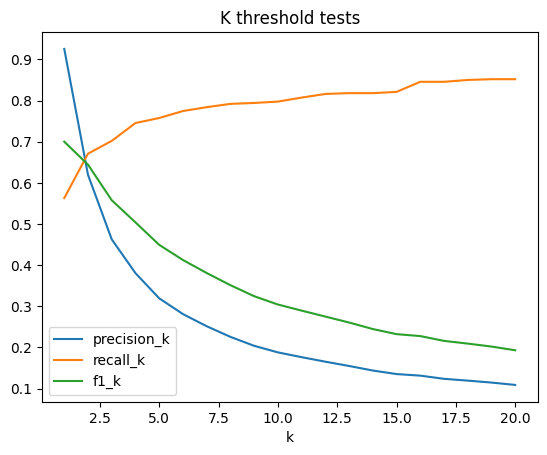

In [26]:
display(k_thresh_tests)

plt.plot(k_thresh_tests["k"], k_thresh_tests["precision_k"], label = "precision_k")
plt.plot(k_thresh_tests["k"], k_thresh_tests["recall_k"], label = "recall_k")
plt.plot(k_thresh_tests["k"], k_thresh_tests["f1_k"], label = "f1_k")
plt.xlabel("k")
plt.title(f"K threshold tests")
plt.legend()
plt.show()

The higher the number of chunks, the lower the precision - this because the large majority of the docs have 1 chunk at most - but the recall raises because for docs with more chunks we leave out a smaller fraction of (possibly) relevant chunks. 

We can try to use a reranker to see if our Precision@K and Recall@K improves. 

## Reranking models

A reranker is model specifically trained to rank the documents based on a query. In this notebook we are going to use a **cross encoder**. Cross encoders are models that process a query and a document **jointly** and output a relevance score for each document.  

The standard semantic search approach uses bi-encoders, where **the query and documents are encoded independently into fixed-size embeddings**. The embeddings are then compared using some similarity measures. While bi-encoders are much faster at retrieval time (since document embeddings can be precomputed and stored in a vector database), they **often sacrifice accuracy due to the lack of interaction between the query and document during encoding**.

By **joint encoding the query with each chunk**, the model should capture **fine-grained interactions between tokens in the query and the document**, leading to accurate relevance judgments.

Let’s examine how our metrics change after applying reranking.

In [27]:
%%time
# Reranking with this token config requires 13minutes to complete all the tests, we can skip it and jump to the charts
k_thresh_tests_reranked = optimize_retriever(vector_store = hpc_store, qa_set = qa_set, max_k = 20, reranker_name = RERANKER)

2025-07-28 16:42:42.518987 - Testing k_threshold 1
2025-07-28 16:43:22.770098 - Testing k_threshold 2
2025-07-28 16:44:02.936232 - Testing k_threshold 3
2025-07-28 16:44:43.098456 - Testing k_threshold 4
2025-07-28 16:45:23.259636 - Testing k_threshold 5
2025-07-28 16:46:03.418688 - Testing k_threshold 6
2025-07-28 16:46:43.583112 - Testing k_threshold 7
2025-07-28 16:47:23.741345 - Testing k_threshold 8
2025-07-28 16:48:03.904720 - Testing k_threshold 9
2025-07-28 16:48:44.060776 - Testing k_threshold 10
2025-07-28 16:49:24.221430 - Testing k_threshold 11
2025-07-28 16:50:04.387229 - Testing k_threshold 12
2025-07-28 16:50:44.554619 - Testing k_threshold 13
2025-07-28 16:51:24.726631 - Testing k_threshold 14
2025-07-28 16:52:05.094475 - Testing k_threshold 15
2025-07-28 16:52:45.461225 - Testing k_threshold 16
2025-07-28 16:53:25.663023 - Testing k_threshold 17
2025-07-28 16:54:05.826152 - Testing k_threshold 18
2025-07-28 16:54:45.985537 - Testing k_threshold 19
2025-07-28 16:55:26.1

,k,precision_k,recall_k,f1_k
0,1,0.895522,0.519004,0.657153
1,2,0.574627,0.628471,0.600344
2,3,0.452736,0.692863,0.547633
3,4,0.373134,0.718776,0.491249
4,5,0.319403,0.742097,0.446591
5,6,0.281095,0.761745,0.410653
6,7,0.247335,0.765224,0.373838
7,8,0.222015,0.771698,0.344825
8,9,0.203980,0.782543,0.323608
9,10,0.186567,0.786033,0.301559


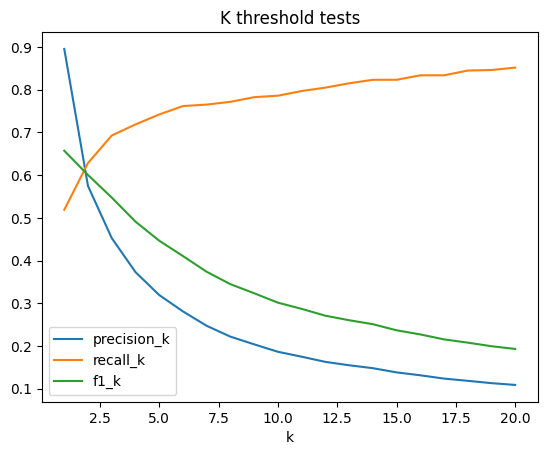

In [28]:
display(k_thresh_tests_reranked)

plt.plot(k_thresh_tests_reranked["k"], k_thresh_tests_reranked["precision_k"], label = "precision_k")
plt.plot(k_thresh_tests_reranked["k"], k_thresh_tests_reranked["recall_k"], label = "recall_k")
plt.plot(k_thresh_tests_reranked["k"], k_thresh_tests_reranked["f1_k"], label = "f1_k")
plt.xlabel("k")
plt.title(f"K threshold tests")
plt.legend()
plt.show()

Let's plot the difference in performance metrics between the ranked version and the non reranked version.

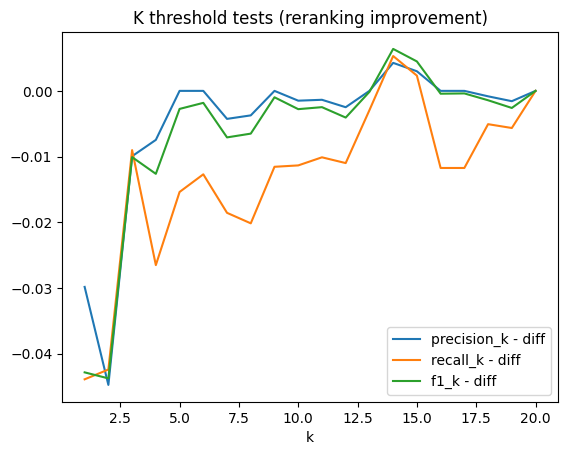

In [29]:
plt.plot(k_thresh_tests_reranked["k"], k_thresh_tests_reranked["precision_k"] - k_thresh_tests["precision_k"], label = "precision_k - diff")
plt.plot(k_thresh_tests_reranked["k"], k_thresh_tests_reranked["recall_k"] - k_thresh_tests["recall_k"], label = "recall_k - diff")
plt.plot(k_thresh_tests_reranked["k"], k_thresh_tests_reranked["f1_k"] - k_thresh_tests["f1_k"], label = "f1_k - diff")
plt.xlabel("k")
plt.title(f"K threshold tests (reranking improvement)")
plt.legend()
plt.show()

Considering the lage majority of documents are short and many of them have 1 or two chunks at most, reranking does not appear to offer significant benefits for this particular document collection.  
However, in scenarios involving multiple document sources and a larger set of relevant candidates, reranking becomes a highly effective technique for identifying and retaining only the most relevant chunks.

# The final retriever 

We are ready to test the complete solution.

In [30]:
class SemanticRetriever():
    def __init__(self, top_k:int, collection_name:str, chroma_path:str, embedder_name:str, reranker_name:str):
        self.reranker_name = reranker_name
        
        lc_embedder = HuggingFaceEmbeddings(model_name = embedder_name)
        vector_store = Chroma(collection_name = collection_name, embedding_function = lc_embedder, persist_directory = chroma_path)
        self.retriever = vector_store.as_retriever(search_kwargs = {"k":20})
        
        if self.reranker_name:
            reranker = HuggingFaceCrossEncoder(model_name=reranker_name)
            compressor = CrossEncoderReranker(model=reranker, top_n=top_k)
            self.compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=self.retriever)

    def generate_answ(self, query:str, llm:ChatOpenAI):
        if self.reranker_name:
            retrieved_chunks:List[Document] = self.compression_retriever.invoke(query)
        else:
            retrieved_chunks:List[Document] = self.retriever.invoke(query)

        query = "[USER_QUERY]:\n\n" + query + "\n\n[RETRIEVED_RESOURCES]:\n\n" 
        for chunk in retrieved_chunks:
            page_content = chunk.page_content
            doc_name = chunk.metadata["doc_name"]
            query += "[DOCUMENT_TITLE]: " + doc_name + "\n[DOCUMENT_CONTENT]:" + page_content + "\n\n"
        return llm.stream([("system", "You are an helpful assistant, answer to the user questions in a precise and concise manner."),("human", query)])

semantic_retriever = SemanticRetriever(top_k = 3, collection_name = "hpc_wiki", chroma_path = chroma_path, embedder_name = EMBEDDER, reranker_name = RERANKER)

## Let's test the system

In [31]:
for question in test_questions:
    print(f"[QUESTION]: {question}")
    answ = semantic_retriever.generate_answ(question, llm)

    print("[ANSWER]: ", end="")
    for chunk in answ:
        print(chunk.content, end="")
    print("\n")

[QUESTION]: What GPUs are available on Leonardo?
[ANSWER]: The GPUs available on the Leonardo supercomputer are NVIDIA Ampere A100-64 accelerators, which are part of the **Booster** partition.

[QUESTION]: Is there any partition without gpus?
[ANSWER]: Yes, there is a partition without GPUs. The "lrd_all_serial" partition on the Leonardo system does not have GPUs. It is designed for serial jobs with a maximum of 4 cores per job and a walltime limit of 4 hours.

[QUESTION]: What GPUs are available on the Cloud?
[ANSWER]: The available GPUs on the Cloud are:

- Nvidia A30
- Nvidia L40s
- Nvidia H100 NVL

[QUESTION]: Can I associate a domain name to a vm?
[ANSWER]: Yes, you can associate a domain name to a virtual machine (VM). To do this, you need to request a DNS name association from CINECA by sending an email to superc@cineca.it. Here are the key points to follow:

1. **Reverse DNS (PTR Record)**: The reverse of the Floating IP must be set to the hostname of the VM. The naming convent

# Improving the system

Some of the answers above are good, but the one on Leonardo's QOS is imprecise, let's check the chunks.

In [32]:
hpc_leonardo_docs = hpc_store.get(where={"doc_name": "leonardo.rst.txt"}, include = ["documents"])
hpc_leonardo_docs

{'ids': ['leonardo.rst.txt__0',
  'leonardo.rst.txt__2145',
  'leonardo.rst.txt__5018',
  'leonardo.rst.txt__7317',
  'leonardo.rst.txt__8013',
  'leonardo.rst.txt__12453',
  'leonardo.rst.txt__12671',
  'leonardo.rst.txt__12699',
  'leonardo.rst.txt__17224',
  'leonardo.rst.txt__18311',
  'leonardo.rst.txt__20840',
  'leonardo.rst.txt__22356',
  'leonardo.rst.txt__24686'],
 'embeddings': None,
 'documents': ['.. _leonardo_card:\n\nLeonardo\n========\n\nLeonardo is the *pre-exascale* Tier-0 supercomputer of the EuroHPC Joint Undertaking (JU), hosted by **CINECA** and currently located at the Bologna DAMA-Technopole in Italy.\nThis guide provides specific information about the **Leonardo** cluster, including details that differ from the general behavior described in the broader HPC Clusters section.\n\n.. |ico2| image:: img/leonardo_logo.png\n   :height: 55px\n   :class: no-scaled-link\n\nAccess to the System\n--------------------\n\nThe machine is reachable via ``ssh`` (secure Shell) p

The problem is that for some specific questions we don't have text associated to a chunk, but we only have "decontestualized" tables, which makes retrieving relevant chunks particularly difficult. Look at this section of our website:

![Leonardo QOS](imgs/leonardo_qos.jpeg)

In fact if we tune our question a bit...

In [33]:
answ = semantic_retriever.generate_answ("What are the partitions available in Leonardo BOOST and their associated QOS?", llm)

for chunk in answ:
    print(chunk.content, end="")

### Partitions and Associated QOS in Leonardo BOOST

1. **Booster Partition (GPU)**
   - **Standard QOS**: `boost_fua_prod` (for EUROfusion users) or `boost_usr_prod` (for all users)
   - **Low-priority QOS**: `qos_fualowprio` (for EUROfusion users when budget is exhausted or when using `FUAL8_LOWPRIO` account)

2. **Data Centric General Purpose (DCGP) Partition (CPU)**
   - **Standard QOS**: `dcgp_fua_prod` (for EUROfusion users) or `dcgp_usr_prod` (for all users)
   - **Low-priority QOS**: `qos_fualowprio` (for EUROfusion users when budget is exhausted or when using `FUA38_LOWPRIO_0` account)

### Low-Priority Jobs
- **Budget Exhaustion**: Use `qos_fualowprio` QOS in `boost_fua_prod` and `dcgp_fua_prod` partitions.
- **Without Budget Exhaustion**: Request `FUAL8_LOWPRIO` (Booster) or `FUA38_LOWPRIO_0` (DCGP) accounts and use `qos_fualowprio` QOS.

### Example Submission Script for Low-Priority Jobs
```bash
#SBATCH --account=<YOUR Project Account or LOWPRIO Project Account>
#SBATCH --

A bit better, but the best relevant chunks still miss relevant context and they are not extracted... In fact, as we were saying before, they have NO RELEVANT context at all sorrounding them.

# A combined approach
The simplest solution would be to combine semantic search with an exact or approximate matching approach. In this case, we aim to retrieve chunks that explicitly mention content related to QOS.

Let's try a classic bag-of-words method. Here, we experiment with using [BM25](https://www.elastic.co/blog/practical-bm25-part-2-the-bm25-algorithm-and-its-variables) to retrieve useful content. BM25 assumes that **the more frequently a term appears in a document, the more relevant the document is** to the query. The **k in the formula ensures that this effect saturates**, so that additional occurrences have diminishing impact. The **score is normalized by document length** to prevent longer documents from being favored. Additionally, **rare terms are given more importance** through the use of the IDF component.

$ BM25(Q, D) = \sum_{i=1}^{n} IDF(q_i) * \frac{f(q_i, D) * (k_1 + 1)}{f(q_i, D) + k_1 * (1 - b + b * \frac{| D |}{avgdl})}$

Where:
- $Q$ is our query with keywords $q_1, ..., q_n$;
- $D$ is a document in our document base;
- $f(q_i, D)$ is the frequency of $q_i$ in document $D$;
- $|D|$ is the document length;
- $ avgdl $ is the average document length in the document collection;
- $k_1$ and $b$ are hyperparams with values usually set as $ b = 2 $ and $ k_1 \in [1.2, 2]$. $k$ controls the therm frequency component, $b$ the document length component;
- $IDF(q_i)$ is the inverse document frequency;

$IDF(q_i) = ln(\frac{N - n(q_i) + 0.5}{n(q_i) + 0.5} + 1)$

With:

- $N$ total number of documents;
- $n(q_i)$ total number of documents containing the term $q_i$

In [34]:
embedder_tokenizer = AutoTokenizer.from_pretrained(EMBEDDER)
tokenized_chunks = [embedder_tokenizer.tokenize(page_chunk, add_special_tokens = False) for page_chunk in hpc_leonardo_docs["documents"]]

bm_25_retriever = BM25Okapi(tokenized_chunks)

In [35]:
pd.options.display.max_colwidth = 5000

query = "What are the names of the QOS queues available on the Leonardo supercomputer BOOSTER partition?"
tokenized_query = embedder_tokenizer.tokenize(query, add_special_tokens = False)

scores = bm_25_retriever.get_scores(tokenized_query)
pd.DataFrame({"scores": scores, "documents": hpc_leonardo_docs["documents"]}).sort_values(by = "scores", ascending = False)

scores  \
0   13.961787   
12  10.287257   
2    7.239758   
9    4.020692   
5    2.786747   
3    2.784774   
1    2.641071   
11   2.631267   
10   1.973369   
7    1.916602   
8    0.592530   
4    0.527483   
6    0.000000   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Still not good for our use case.

# Contextual retrieval

Contextual retrieval is a technique [introduced](https://www.anthropic.com/news/contextual-retrieval) by Anthropic which consist in enriching a text chunk with context before generating its embedding.

This context is produced by a large language model (LLM), which takes two inputs: the full document and the specific chunks that need contextualization. The model then returns a description of each chunk’s role within the overall document. The LLM generated description is prepended to the chunk before embedding. This **will cause the embedding to capture not only local content but also higher-level contextual meaning**.

In [36]:
# Straight from https://www.anthropic.com/news/contextual-retrieval
def generate_context(chunk_content:Document, full_document:Document, llm) -> str:
    """
        Returns a contextualized chunk.

        Arguments:
            - chunk_content: The chunk that must be contextualized;
            - full_document: The entire langchain document to be used for contextualization;
            - llm: The llm client used to create the context;


        Returns:
            str: A string containing the context of the chunk
    """
    contextual_retrieval_prompt = f"""[DOCUMENT]:
    {full_document.page_content}
    
    [DOCUMENT_CHUNK]:
    {chunk_content.page_content}

    [TASK]:
    Please give a short succinct context to situate this chunk within the overall document for the purposes of improving search retrieval of the chunk. Answer only with the succinct context and nothing else. 
    """

    chunk_context = llm.invoke([("system", "You are an helpful assistant, answer to the user questions in a precise and concise manner."),
                                ("human", contextual_retrieval_prompt)]).content
    return chunk_context

In [37]:
%%time
leonardo_doc = [document for document in documents if document.metadata["doc_name"] == "leonardo.rst.txt"][0]
leonardo_chunks = [document for document in chunks if document.metadata["doc_name"] == "leonardo.rst.txt"]

# Send up to 12 queries in parallel
with ThreadPoolExecutor(max_workers=12) as e:
    chunk_contexts = [*e.map(partial(generate_context, llm = llm, full_document = leonardo_doc), leonardo_chunks)]

chunk_contexts

CPU times: user 32.1 ms, sys: 3.95 ms, total: 36.1 ms
Wall time: 3.43 s


['This chunk is part of the "Hardware Details" section under "System Architecture" in the Leonardo supercomputer documentation. It provides specific details about the Booster partition, including the types of compute blades, processors, accelerators, and other hardware specifications.',
 'This chunk provides detailed hardware specifications for the two main partitions of the Leonardo supercomputer: the Booster partition, which is GPU-based, and the DCGP partition, which is CPU-based. It includes information on the models, number of racks and nodes, processors, accelerators, local storage, RAM, peak performance (Rmax), internal network, and storage capacity for each partition.',
 'This chunk is part of the "File Systems and Data Management" section of the Leonardo supercomputer documentation, specifically detailing the usage and characteristics of the `$TMPDIR` environment variable across different node types.',
 'This chunk is part of the "Job Managing and Slurm Partitions" section of 

Let's embed the chunks again and check the new similarity.

In [38]:
contextualized_chunks = []

for i in range(len(leonardo_chunks)):
    chunk_content = f"""[CONTEXT]:
    {chunk_contexts[i]}

    [CHUNK_CONTENT]:
    {leonardo_chunks[i].page_content}
    """

    contextualized_chunks.append(chunk_content)

contextualized_embeddings = embedder.encode(contextualized_chunks)

In [39]:
pd.options.display.max_colwidth = 5000
scores = cosine_similarity(embedder.encode(["What are the names of the QOS queues available on the Leonardo supercomputer BOOSTER partition?"]), contextualized_embeddings).tolist()[0]

pd.DataFrame({"scores": scores, "documents": [document.page_content for document in leonardo_chunks]}).sort_values(by = "scores", ascending = False)

scores  \
3   0.666583   
4   0.648405   
0   0.630339   
1   0.621514   
5   0.618120   
10  0.616491   
8   0.601556   
7   0.555121   
11  0.522800   
6   0.519628   
2   0.505805   
9   0.499677   
12  0.498936   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

The first chunks are now more relevant. Let’s re-embed our entire document base using context.

In [40]:
%%time
# Drop this db if exists
chroma_client = chromadb.PersistentClient(path = chroma_path)
try:
    chroma_client.delete_collection("hpc_contextualized_wiki")
except NotFoundError as e:
    pass

collection = chroma_client.create_collection(name = "hpc_contextualized_wiki")

# For each document, split it and generate contextualized chunks
for document in documents:
    document_contextualized_chunks = []
    
    document_chunks = rcts_chunker.split_documents([document])

    # You can save also the contexts as metadata in the vector db, it could be interesting...
    with ThreadPoolExecutor(max_workers=12) as e:
        chunk_contexts = [*e.map(partial(generate_context, llm = llm, full_document = document), document_chunks)]

    for i in range(len(document_chunks)):
        chunk_content = f"""[CONTEXT]:
        {chunk_contexts[i]}
    
        [CHUNK_CONTENT]:
        {document_chunks[i].page_content}
        """
    
        document_contextualized_chunks.append(chunk_content)
    # Embed the contextualized chunk content
    embeddings = embedder.encode(document_contextualized_chunks)
    
    # Add all chunks to the collection
    collection.add(documents = [doc.page_content for doc in document_chunks],
                   metadatas  = [doc.metadata for doc in document_chunks],
                   ids = [doc.metadata["doc_name"] + "__" + \
                          str(doc.metadata["start_index"]) for doc in document_chunks],
                   embeddings = embeddings)

CPU times: user 9.61 s, sys: 429 ms, total: 10 s
Wall time: 2min 2s


Let’s test whether the new database performs better than the old one using our test suite.

In [41]:
hpc_contextualized_store = Chroma(collection_name = "hpc_contextualized_wiki", embedding_function = lc_embedder, persist_directory= chroma_path)

k_thresh_tests_contextualized = optimize_retriever(vector_store = hpc_contextualized_store, qa_set = qa_set, max_k = 20, reranker_name = None)

2025-07-28 16:58:55.500175 - Testing k_threshold 1
2025-07-28 16:58:56.800131 - Testing k_threshold 2
2025-07-28 16:58:58.089317 - Testing k_threshold 3
2025-07-28 16:58:59.393307 - Testing k_threshold 4
2025-07-28 16:59:00.691047 - Testing k_threshold 5
2025-07-28 16:59:01.987567 - Testing k_threshold 6
2025-07-28 16:59:03.284972 - Testing k_threshold 7
2025-07-28 16:59:04.584109 - Testing k_threshold 8
2025-07-28 16:59:05.884367 - Testing k_threshold 9
2025-07-28 16:59:07.187672 - Testing k_threshold 10
2025-07-28 16:59:08.493321 - Testing k_threshold 11
2025-07-28 16:59:09.828080 - Testing k_threshold 12
2025-07-28 16:59:11.134806 - Testing k_threshold 13
2025-07-28 16:59:12.442254 - Testing k_threshold 14
2025-07-28 16:59:13.751521 - Testing k_threshold 15
2025-07-28 16:59:15.066636 - Testing k_threshold 16
2025-07-28 16:59:16.386172 - Testing k_threshold 17
2025-07-28 16:59:17.701877 - Testing k_threshold 18
2025-07-28 16:59:19.020208 - Testing k_threshold 19
2025-07-28 16:59:20.3

,k,precision_k,recall_k,f1_k
0,1,0.970149,0.580838,0.726634
1,2,0.671642,0.723887,0.696786
2,3,0.512438,0.772284,0.616083
3,4,0.421642,0.809344,0.554439
4,5,0.361194,0.830378,0.503415
5,6,0.308458,0.833857,0.450331
6,7,0.275053,0.843199,0.414798
7,8,0.248134,0.850351,0.384168
8,9,0.227197,0.857803,0.359245
9,10,0.210448,0.865013,0.338534


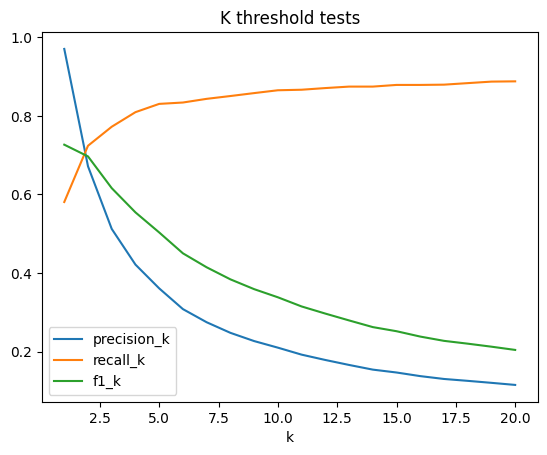

In [42]:
display(k_thresh_tests_contextualized)

plt.plot(k_thresh_tests_contextualized["k"], k_thresh_tests_contextualized["precision_k"], label = "precision_k")
plt.plot(k_thresh_tests_contextualized["k"], k_thresh_tests_contextualized["recall_k"], label = "recall_k")
plt.plot(k_thresh_tests_contextualized["k"], k_thresh_tests_contextualized["f1_k"], label = "f1_k")
plt.xlabel("k")
plt.title(f"K threshold tests")
plt.legend()
plt.show()

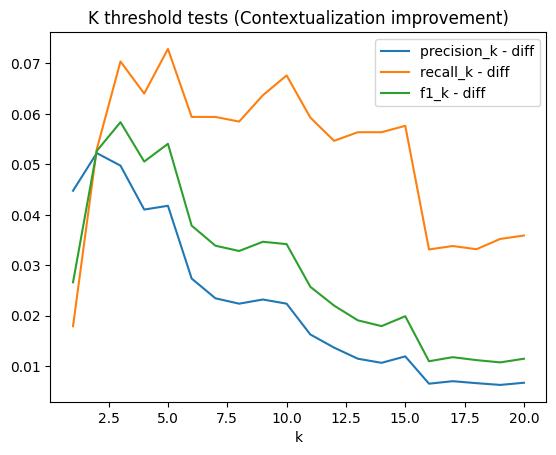

In [43]:
plt.plot(k_thresh_tests_contextualized["k"], k_thresh_tests_contextualized["precision_k"] - k_thresh_tests["precision_k"], label = "precision_k - diff")
plt.plot(k_thresh_tests_contextualized["k"], k_thresh_tests_contextualized["recall_k"] - k_thresh_tests["recall_k"], label = "recall_k - diff")
plt.plot(k_thresh_tests_contextualized["k"], k_thresh_tests_contextualized["f1_k"] - k_thresh_tests["f1_k"], label = "f1_k - diff")
plt.xlabel("k")
plt.title(f"K threshold tests (Contextualization improvement)")
plt.legend()
plt.show()

In [44]:
semantic_retriever_context = SemanticRetriever(top_k = 3, collection_name = "hpc_contextualized_wiki", chroma_path = chroma_path, embedder_name = EMBEDDER, reranker_name = None)

In [45]:
answ = semantic_retriever_context.generate_answ("What are the partitions available in Leonardo BOOST and their associated QOS?", llm)

for chunk in answ:
    print(chunk.content, end="")

The partitions available in Leonardo BOOST and their associated QOS are as follows:

1. **boost_usr_prod**
   - **QOS**: normal
     - **#Cores/#GPU per job**: 64 nodes
     - **Walltime**: 24:00:00
     - **Max Nodes/cores/GPUs/user**: Not specified
     - **Priority**: 40
   - **QOS**: boost_qos_dbg
     - **#Cores/#GPU per job**: 2 nodes
     - **Walltime**: 00:30:00
     - **Max Nodes/cores/GPUs/user**: 2 nodes / 64 cores / 8 GPUs
     - **Priority**: 80
   - **QOS**: boost_qos_bprod
     - **#Cores/#GPU per job**: min = 65 nodes, max = 256 nodes
     - **Walltime**: 24:00:00
     - **Max Nodes/cores/GPUs/user**: 256 nodes
     - **Priority**: 60
   - **QOS**: boost_qos_lprod
     - **#Cores/#GPU per job**: 3 nodes
     - **Walltime**: 4-00:00:00
     - **Max Nodes/cores/GPUs/user**: 3 nodes / 12 GPUs
     - **Priority**: 40

2. **boost_fua_dbg**
   - **QOS**: normal
     - **#Cores/#GPU per job**: 2 nodes
     - **Walltime**: 00:10:00
     - **Max Nodes/cores/GPUs/user**: 2 nodes 

Now, that's an answer...

In [46]:
for question in test_questions:
    print(f"[QUESTION]: {question}")
    answ = semantic_retriever_context.generate_answ(question, llm)

    print("[ANSWER]: ", end="")
    for chunk in answ:
        print(chunk.content, end="")
    print("\n")

[QUESTION]: What GPUs are available on Leonardo?
[ANSWER]: The Leonardo supercomputer features the following GPUs:

- **NVIDIA Ampere A100-64 accelerators** in the Booster partition. Each node in this partition has 4 NVIDIA Ampere A100 custom GPUs, each with 64 GiB HBM2e memory and NVLink 3.0 (200 GB/s) connectivity.

[QUESTION]: Is there any partition without gpus?
[ANSWER]: Yes, there are partitions without GPUs. Here are some examples:

1. **Galileo**:
   - `g100_all_serial` (default)
   - `g100_usr_dbg`
   - `g100_usr_prod`
   - `g100_usr_bmem`

2. **Leonardo**:
   - `lrd_all_serial` (default)
   - `dcgp_usr_prod`
   - `dcgp_fua_dbg`
   - `dcgp_fua_prod`

3. **Pitagora**:
   - `dcgp_usr_prod`
   - `dcgp_fua_dbg`
   - `dcgp_fua_prod`

These partitions are designed for CPU-only computations and do not include GPU resources.

[QUESTION]: What GPUs are available on the Cloud?
[ANSWER]: The available GPUs on the Cloud are:

- Nvidia A30
- Nvidia L40s
- Nvidia H100 NVL

[QUESTION]: Can I

# A few considerations about contextual retrieval

1. Production pipelines with many calls to LLMs become costly and slow, especially if you need to re-index your data frequently. An interesting approach here would be to generate context only for chunks containing tables. You can identify chunks containing only tables by using well-written regular expressions or by checking the entropy of the chunk.
2. Simple approaches (e.g., BM25) are better if they work well with your data.

# Final remarks

When you create a RAG system, you don’t chunk just for the sake of chunking. You want to have a testing set to evaluate the performance of various approaches. Everything must be measured, and improvements must be quantified.

You also want a reference set of expert-made questions to quantify the performance of your system and identify which techniques produce the best results.

In [47]:
print(f"Total execution time {datetime.now() - t0}")

Total execution time 0:20:49.053584
